In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
mnist_dataset = torchvision.datasets.MNIST(
    root="mnist_dataset",
    download=True,
    train=True,
    transform=ToTensor()
)

2


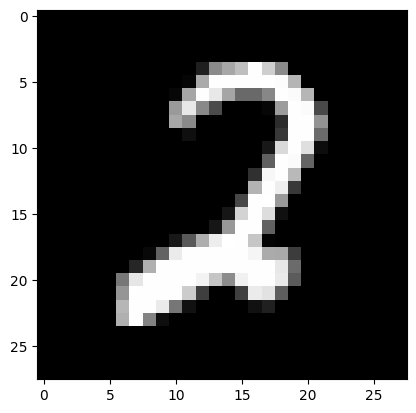

In [3]:
img,label = mnist_dataset[torch.randint(len(mnist_dataset),size=(1,))[0]]

plt.imshow(img.squeeze(),cmap="gray")
print(label)

In [4]:
train,val,test = torch.utils.data.random_split(mnist_dataset,[0.8, 0.1, 0.1])

In [5]:
from torch import nn

class ConvNet(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,kernel_size=3),
            nn.ReLU(),
            nn.Flatten()
        )
        self.classifiyer = nn.Sequential(
            nn.Linear(128*3*3,110),
            nn.ReLU(),
            nn.Linear(110,10),
            nn.Softmax(1)
        )

    def forward(self,x):
        x = self.encoder(x)
        x = self.classifiyer(x)

        return x

In [7]:
Conv_Clasifier = ConvNet().cuda()

Categoría predicha: 7
Categoría real: 0


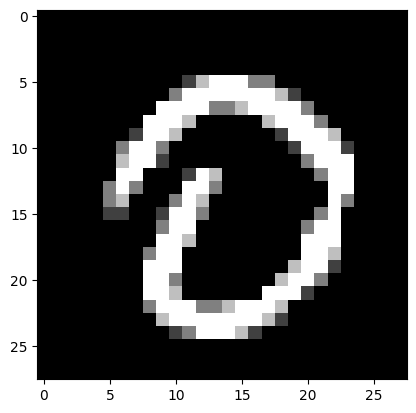

In [8]:
#Try untrained net
img,lbl = train[torch.randint(0,len(train),size=(1,))]

img = img[None,:]

logits = Conv_Clasifier(img.cuda())
print("Categoría predicha:",logits.argmax().item())
print("Categoría real:",lbl)
plt.imshow(img.squeeze(),cmap="grey");


In [9]:
batch_size=250
train_loader = DataLoader(
    dataset=train,
    shuffle=True,
    batch_size=batch_size
)
imgs_batch, lbls_batch = next(iter(train_loader))

val_loader = torch.utils.data.DataLoader(
    dataset=val,
    shuffle=True,
    batch_size=batch_size
)

In [10]:
epochs = 30
learning_rate = 0.01

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Conv_Clasifier.parameters(), lr=learning_rate)

In [11]:
def train_loop(loader:torch.utils.data.DataLoader, model : nn.Module, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    train_size = len(loader.dataset)

    model.train()   #Preparo el modelo para el entrenamiento

    train_losses, train_accuracy = 0,0

    for nlote,(x,y) in enumerate(loader):
        x,y = x.cuda(), y.cuda()

        # Forward Pass
        logits = model(x)

        # Backpropagation
        loss = loss_fn(logits,y)    #Calculo de loss
        loss.backward()             #Calculo de gradiente
        optimizer.step()            #Actualización de parámetros
        optimizer.zero_grad()       #Limpieza del optimizador

        #Guardamos algunas caractgerísticas para plotear al final
        train_losses += loss.item()
        train_accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

        #Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote: ",nlote)
            print("Loss: ",loss.item())

    train_losses /= nlotes
    train_accuracy /= train_size
    
    print()
    print("\tAccuracy/Loss Promedio")
    print(f"\t\tEntrenamiento: {(100*train_accuracy):>0.1f}% / {train_losses:>8f}")

In [12]:
def val_loop(loader:torch.utils.data.DataLoader, model:nn.Module, loss_fn:callable):
    
    val_size = len(loader.dataset)
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses, val_accuracy = 0,0

    with torch.no_grad():       #Calcelo el calculo del gradiente
        for x,y in loader:
            
            x,y = x.cuda(), y.cuda()

            logits = model(x)       # Inferencia
            
            val_losses += loss_fn(logits,y.long()).item()
            val_accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

    val_losses /= nlotes
    val_accuracy /= val_size

    print(f"\t\tValidación: {(100*val_accuracy):>0.1f}% / {val_losses:>8f}")



In [66]:
for epoch in range(10):
    print(f"Itenración: {(epoch + 1)} / {epochs} -----------------------------")
    
    #Train
    train_loop(train_loader,Conv_Clasifier,optimizer,loss)

    #Validation
    val_loop(val_loader,Conv_Clasifier,loss)

print("Finalizado entrenamiento del modelo!")

Itenración: 1 / 30 -----------------------------
Nº de lote:  0
Loss:  1.6772983074188232
Nº de lote:  10
Loss:  1.6505285501480103
Nº de lote:  20
Loss:  1.650424599647522
Nº de lote:  30
Loss:  1.645974040031433
Nº de lote:  40
Loss:  1.6677982807159424
Nº de lote:  50
Loss:  1.6003206968307495
Nº de lote:  60
Loss:  1.620422601699829
Nº de lote:  70
Loss:  1.6515661478042603
Nº de lote:  80
Loss:  1.682708740234375
Nº de lote:  90
Loss:  1.6653642654418945
Nº de lote:  100
Loss:  1.6214420795440674
Nº de lote:  110
Loss:  1.6260348558425903
Nº de lote:  120
Loss:  1.6374280452728271
Nº de lote:  130
Loss:  1.650679111480713
Nº de lote:  140
Loss:  1.608312726020813
Nº de lote:  150
Loss:  1.6689972877502441
Nº de lote:  160
Loss:  1.6144055128097534
Nº de lote:  170
Loss:  1.6435641050338745
Nº de lote:  180
Loss:  1.6650311946868896
Nº de lote:  190
Loss:  1.643928050994873

	Accuracy/Loss Promedio
		Entrenamiento: 82.6% / 1.641118
		Validación: 82.4% / 1.641746
Itenración: 2 / 30 

Clase real:  9
Clase Predicha:  9


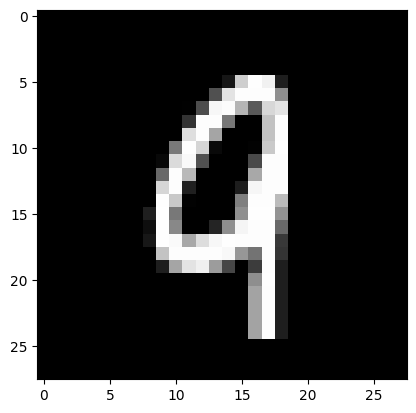

In [64]:
img,lbl = val[torch.randint(0,len(val),size=(1,))]

img = img[None,:].cuda()

logits = Conv_Clasifier(img)
lbl_predict = logits.argmax().item()
print("Clase real: ",lbl)
print("Clase Predicha: ",lbl_predict)

plt.imshow(img.cpu().squeeze(),cmap="grey");

In [65]:
val_loop(val_loader,Conv_Clasifier,loss)

		Validación: 82.4% / 1.643757
